In [1]:
# 업데이트 내용
# 건물연식과 계약날짜 검색범위 조정할 필요 없이 가장 자주 쓰이는 건물연식, 계약날짜 조합 파일들 전부 생성

In [2]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [3]:
target_gu = '마포구' # 구 명
target_dong = '망원' # 동 명: 동 명에서 마지막 글자 '동' 뺄 것
#target_purpose = '준주거' # 종 명: 건드릴 필요 없음
target_building_age = 3 # 건물연식: 건드릴 필요 없음
target_period = 36 # 계약날짜 검색범위: 건드릴 필요 없음

In [4]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [5]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20210824'

In [6]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [7]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [8]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [9]:
apart_df = data_prep('아파트', '매매')
apart_df['부동산유형'] = '아파트'
print(apart_df.shape)
apart_df.head()

16it [00:02,  7.45it/s]


(1208250, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 655-2,언주로 103,개포2차현대아파트(220),77.75,59500,7,1988,18,2006-03-10,765.273312,33,아파트
1,서울특별시 강남구 개포동 655-2,언주로 103,개포2차현대아파트(220),77.75,60000,6,1988,18,2006-03-29,771.704180,33,아파트
2,서울특별시 강남구 개포동 655-2,언주로 103,개포2차현대아파트(220),77.75,67000,9,1988,18,2006-04-29,861.736334,33,아파트
3,서울특별시 강남구 개포동 655-2,언주로 103,개포2차현대아파트(220),77.75,60000,4,1988,18,2006-06-01,771.704180,33,아파트
4,서울특별시 강남구 개포동 655-2,언주로 103,개포2차현대아파트(220),77.75,72250,5,1988,18,2006-10-20,929.260450,33,아파트


In [10]:
yunrip_df = data_prep('연립다세대', '매매')
yunrip_df['부동산유형'] = '연립다세대'
print(yunrip_df.shape)
yunrip_df.head()

16it [00:01, 10.71it/s]


(649000, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0,연립다세대
1,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0,연립다세대
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0,연립다세대
3,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0,연립다세대
4,서울특별시 강남구 개포동 1175-2,논현로6길 36-8,강남파크,49.43,23.70,17000,4,1993.0,13.0,2006-07-19,343.920696,28.0,연립다세대


In [11]:
officetel_df = data_prep('오피스텔', '매매')
officetel_df['부동산유형'] = '오피스텔'
print(officetel_df.shape)
officetel_df.head()

16it [00:00, 41.12it/s]


(184709, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,6400,8,1997.0,9.0,2006-01-10,197.287300,24.0,오피스텔
1,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7100,7,1997.0,9.0,2006-01-10,218.865598,24.0,오피스텔
2,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7300,11,1997.0,9.0,2006-01-11,225.030826,24.0,오피스텔
3,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,31.91,7500,10,1997.0,9.0,2006-01-18,235.036039,24.0,오피스텔
4,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7400,15,1997.0,9.0,2006-01-19,228.113440,24.0,오피스텔


In [12]:
yunrip_df = yunrip_df.drop(columns=['대지권면적(㎡)'])
house_df = pd.concat([apart_df, yunrip_df, officetel_df]).sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
print(house_df.shape)
house_df.head()

(2041959, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 1164-0,논현로2길 6,골드캐슬,58.05,57500,2,2017.0,1.0,2018-01-20,990.525409,4.0,연립다세대
1,서울특별시 강남구 개포동 1164-0,논현로2길 6,골드캐슬,58.05,57000,1,2017.0,1.0,2018-06-01,981.912145,4.0,연립다세대
2,서울특별시 강남구 개포동 1164-0,논현로2길 6,골드캐슬,58.05,63000,2,2017.0,2.0,2019-01-19,1085.271318,4.0,연립다세대
3,서울특별시 강남구 개포동 1164-12,논현로2길 34,새롬(1164-12),71.72,64500,7,2000.0,17.0,2017-09-23,899.330731,21.0,아파트
4,서울특별시 강남구 개포동 1164-12,논현로2길 34,새롬(1164-12),73.50,29800,4,2000.0,6.0,2006-10-18,405.442177,21.0,아파트


In [13]:
'''land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()'''

"land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')\nprint(land_specs_df.shape)\nland_specs_df.head()"

In [14]:
'''last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()'''

"last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)\nprint(last_df.shape)\nlast_df.head()"

In [15]:
'''house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)'''

"house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)\nprint(house_merge_df.shape)"

In [16]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
#house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
#house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [17]:
house_df['일괄계약'] = 'N'

In [18]:
#house_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)

In [19]:
'''print(house_df.shape)
house_df.head()'''

'print(house_df.shape)\nhouse_df.head()'

In [20]:
def identify_bulk_contract(df):
    df = df.copy()
    
    for addr in tqdm(df['지번주소'].unique()):
        addr_df = df[df['지번주소'] == addr]
        
        for btyear in addr_df['건축년도'].unique():
            btyear_df = addr_df[addr_df['건축년도'] == btyear]
        
            for contract_date in btyear_df['계약날짜'].unique():
                contract_date_df = btyear_df[btyear_df['계약날짜'] == contract_date]

                if contract_date_df.shape[0] >= 5:
                    df.loc[contract_date_df.index, '일괄계약'] = 'Y'
    
    return df

In [21]:
target_1_12_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=12)))
    &(house_df['건물연식'] <= 1)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_1_12_df.shape)
target_1_12_df.head()

(55, 15)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약
1094787,서울특별시 마포구 망원동 380-24,월드컵로13길 19-14,아가도스2,27.46,37000,3,2020.0,0.0,2020-09-18,1347.414421,1.0,연립다세대,마포구,망원동,N
1094788,서울특별시 마포구 망원동 380-24,월드컵로13길 19-14,아가도스2,27.46,37800,2,2020.0,0.0,2020-10-20,1376.547706,1.0,연립다세대,마포구,망원동,N
1094789,서울특별시 마포구 망원동 380-24,월드컵로13길 19-1,아가도스2,27.70,37800,3,2020.0,0.0,2020-09-28,1364.620939,1.0,연립다세대,마포구,망원동,N
1094790,서울특별시 마포구 망원동 380-24,월드컵로13길 19-14,아가도스2,27.70,37800,2,2020.0,1.0,2021-01-12,1364.620939,1.0,연립다세대,마포구,망원동,N
1094791,서울특별시 마포구 망원동 380-24,월드컵로13길 19-14,아가도스2,28.42,41300,4,2020.0,1.0,2021-06-08,1453.201970,1.0,연립다세대,마포구,망원동,N


In [22]:
target_2_24_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=24)))
    &(house_df['건물연식'] <= 2)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_2_24_df.shape)
target_2_24_df.head()

(117, 15)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약
1094787,서울특별시 마포구 망원동 380-24,월드컵로13길 19-14,아가도스2,27.46,37000,3,2020.0,0.0,2020-09-18,1347.414421,1.0,연립다세대,마포구,망원동,N
1094788,서울특별시 마포구 망원동 380-24,월드컵로13길 19-14,아가도스2,27.46,37800,2,2020.0,0.0,2020-10-20,1376.547706,1.0,연립다세대,마포구,망원동,N
1094789,서울특별시 마포구 망원동 380-24,월드컵로13길 19-1,아가도스2,27.70,37800,3,2020.0,0.0,2020-09-28,1364.620939,1.0,연립다세대,마포구,망원동,N
1094790,서울특별시 마포구 망원동 380-24,월드컵로13길 19-14,아가도스2,27.70,37800,2,2020.0,1.0,2021-01-12,1364.620939,1.0,연립다세대,마포구,망원동,N
1094791,서울특별시 마포구 망원동 380-24,월드컵로13길 19-14,아가도스2,28.42,41300,4,2020.0,1.0,2021-06-08,1453.201970,1.0,연립다세대,마포구,망원동,N


In [23]:
target_3_36_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=36)))
    &(house_df['건물연식'] <= 3)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_3_36_df.shape)
target_3_36_df.head()

(157, 15)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약
1094787,서울특별시 마포구 망원동 380-24,월드컵로13길 19-14,아가도스2,27.46,37000,3,2020.0,0.0,2020-09-18,1347.414421,1.0,연립다세대,마포구,망원동,N
1094788,서울특별시 마포구 망원동 380-24,월드컵로13길 19-14,아가도스2,27.46,37800,2,2020.0,0.0,2020-10-20,1376.547706,1.0,연립다세대,마포구,망원동,N
1094789,서울특별시 마포구 망원동 380-24,월드컵로13길 19-1,아가도스2,27.70,37800,3,2020.0,0.0,2020-09-28,1364.620939,1.0,연립다세대,마포구,망원동,N
1094790,서울특별시 마포구 망원동 380-24,월드컵로13길 19-14,아가도스2,27.70,37800,2,2020.0,1.0,2021-01-12,1364.620939,1.0,연립다세대,마포구,망원동,N
1094791,서울특별시 마포구 망원동 380-24,월드컵로13길 19-14,아가도스2,28.42,41300,4,2020.0,1.0,2021-06-08,1453.201970,1.0,연립다세대,마포구,망원동,N


In [24]:
target_5_60_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=60)))
    &(house_df['건물연식'] <= 5)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_5_60_df.shape)
target_5_60_df.head()

(419, 15)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약
1094502,서울특별시 마포구 망원동 236-4,희우정로13길 29,삼성캐슬(236-4),45.3,47000,5,2017.0,3.0,2020-01-18,1037.527594,4.0,연립다세대,마포구,망원동,N
1094742,서울특별시 마포구 망원동 379-34,동교로9길 29-8,(379-34),19.0,14300,3,2016.0,2.0,2018-05-10,752.631579,5.0,연립다세대,마포구,망원동,N
1094743,서울특별시 마포구 망원동 379-34,동교로9길 29-8,(379-34),19.0,14300,3,2016.0,2.0,2018-05-10,752.631579,5.0,연립다세대,마포구,망원동,N
1094744,서울특별시 마포구 망원동 379-34,동교로9길 29-8,(379-34),19.0,14300,2,2016.0,2.0,2018-05-10,752.631579,5.0,연립다세대,마포구,망원동,N
1094745,서울특별시 마포구 망원동 379-34,동교로9길 29-8,(379-34),19.0,14300,2,2016.0,2.0,2018-05-10,752.631579,5.0,연립다세대,마포구,망원동,N


In [25]:
target_1_12_df = identify_bulk_contract(target_1_12_df)

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 399.92it/s]


In [26]:
target_2_24_df = identify_bulk_contract(target_2_24_df)

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 394.65it/s]


In [27]:
target_3_36_df = identify_bulk_contract(target_3_36_df)

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 408.07it/s]


In [28]:
target_5_60_df = identify_bulk_contract(target_5_60_df)

100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 355.85it/s]


In [29]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]

sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])

sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

sales_idx_df.columns = sales_idx_cols_list

In [30]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        idx = df[year+'년 '+month+'월_지수'].iloc[0]
        
        return idx

In [31]:
def get_index_applied_prices(df):
    df = df.copy()
    
    last_idx = sales_idx_df.iloc[0,-2]
    
    last_date = sales_idx_df.columns[-1].split('_')[0]
    
    last_date = last_date.split(' ')[0].replace('년','') + '-' + last_date.split(' ')[1].replace('월','') + '-01'
    
    target_upper_limit_df = df[df['계약날짜'] < pd.to_datetime(last_date)]
    target_upper_limit_df['계약날짜_실거래지수'] = target_upper_limit_df['계약날짜'].apply(get_sales_idx)
    target_upper_limit_df['지수적용단가'] = target_upper_limit_df['단가(만원/㎡)'] / target_upper_limit_df['계약날짜_실거래지수'] * last_idx
    df['지수적용단가'] = df['단가(만원/㎡)']
    df.loc[target_upper_limit_df.index, '지수적용단가'] = target_upper_limit_df['지수적용단가']
    df['지수적용날짜'] = df['계약날짜']
    df.loc[target_upper_limit_df.index, '지수적용날짜'] = pd.to_datetime(last_date[:-2] + '01')
    
    return df

In [32]:
target_1_12_df = get_index_applied_prices(target_1_12_df)
print(target_1_12_df.shape)
target_1_12_df.head()

(55, 17)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약,지수적용단가,지수적용날짜
1094787,서울특별시 마포구 망원동 380-24,월드컵로13길 19-14,아가도스2,27.46,37000,3,2020.0,0.0,2020-09-18,1347.414421,1.0,연립다세대,마포구,망원동,N,1463.972211,2021-05-01
1094788,서울특별시 마포구 망원동 380-24,월드컵로13길 19-14,아가도스2,27.46,37800,2,2020.0,0.0,2020-10-20,1376.547706,1.0,연립다세대,마포구,망원동,N,1494.692105,2021-05-01
1094789,서울특별시 마포구 망원동 380-24,월드컵로13길 19-1,아가도스2,27.70,37800,3,2020.0,0.0,2020-09-28,1364.620939,1.0,연립다세대,마포구,망원동,N,1482.667175,2021-05-01
1094790,서울특별시 마포구 망원동 380-24,월드컵로13길 19-14,아가도스2,27.70,37800,2,2020.0,1.0,2021-01-12,1364.620939,1.0,연립다세대,마포구,망원동,N,1422.307433,2021-05-01
1094791,서울특별시 마포구 망원동 380-24,월드컵로13길 19-14,아가도스2,28.42,41300,4,2020.0,1.0,2021-06-08,1453.201970,1.0,연립다세대,마포구,망원동,N,1453.201970,2021-06-08


In [33]:
target_2_24_df = get_index_applied_prices(target_2_24_df)
print(target_2_24_df.shape)
target_2_24_df.head()

(117, 17)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약,지수적용단가,지수적용날짜
1094787,서울특별시 마포구 망원동 380-24,월드컵로13길 19-14,아가도스2,27.46,37000,3,2020.0,0.0,2020-09-18,1347.414421,1.0,연립다세대,마포구,망원동,N,1463.972211,2021-05-01
1094788,서울특별시 마포구 망원동 380-24,월드컵로13길 19-14,아가도스2,27.46,37800,2,2020.0,0.0,2020-10-20,1376.547706,1.0,연립다세대,마포구,망원동,N,1494.692105,2021-05-01
1094789,서울특별시 마포구 망원동 380-24,월드컵로13길 19-1,아가도스2,27.70,37800,3,2020.0,0.0,2020-09-28,1364.620939,1.0,연립다세대,마포구,망원동,N,1482.667175,2021-05-01
1094790,서울특별시 마포구 망원동 380-24,월드컵로13길 19-14,아가도스2,27.70,37800,2,2020.0,1.0,2021-01-12,1364.620939,1.0,연립다세대,마포구,망원동,N,1422.307433,2021-05-01
1094791,서울특별시 마포구 망원동 380-24,월드컵로13길 19-14,아가도스2,28.42,41300,4,2020.0,1.0,2021-06-08,1453.201970,1.0,연립다세대,마포구,망원동,N,1453.201970,2021-06-08


In [34]:
target_3_36_df = get_index_applied_prices(target_3_36_df)
print(target_3_36_df.shape)
target_3_36_df.head()

(157, 17)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약,지수적용단가,지수적용날짜
1094787,서울특별시 마포구 망원동 380-24,월드컵로13길 19-14,아가도스2,27.46,37000,3,2020.0,0.0,2020-09-18,1347.414421,1.0,연립다세대,마포구,망원동,N,1463.972211,2021-05-01
1094788,서울특별시 마포구 망원동 380-24,월드컵로13길 19-14,아가도스2,27.46,37800,2,2020.0,0.0,2020-10-20,1376.547706,1.0,연립다세대,마포구,망원동,N,1494.692105,2021-05-01
1094789,서울특별시 마포구 망원동 380-24,월드컵로13길 19-1,아가도스2,27.70,37800,3,2020.0,0.0,2020-09-28,1364.620939,1.0,연립다세대,마포구,망원동,N,1482.667175,2021-05-01
1094790,서울특별시 마포구 망원동 380-24,월드컵로13길 19-14,아가도스2,27.70,37800,2,2020.0,1.0,2021-01-12,1364.620939,1.0,연립다세대,마포구,망원동,N,1422.307433,2021-05-01
1094791,서울특별시 마포구 망원동 380-24,월드컵로13길 19-14,아가도스2,28.42,41300,4,2020.0,1.0,2021-06-08,1453.201970,1.0,연립다세대,마포구,망원동,N,1453.201970,2021-06-08


In [35]:
target_5_60_df = get_index_applied_prices(target_5_60_df)
print(target_5_60_df.shape)
target_5_60_df.head()

(419, 17)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약,지수적용단가,지수적용날짜
1094502,서울특별시 마포구 망원동 236-4,희우정로13길 29,삼성캐슬(236-4),45.3,47000,5,2017.0,3.0,2020-01-18,1037.527594,4.0,연립다세대,마포구,망원동,N,1216.881710,2021-05-01
1094742,서울특별시 마포구 망원동 379-34,동교로9길 29-8,(379-34),19.0,14300,3,2016.0,2.0,2018-05-10,752.631579,5.0,연립다세대,마포구,망원동,Y,947.213229,2021-05-01
1094743,서울특별시 마포구 망원동 379-34,동교로9길 29-8,(379-34),19.0,14300,3,2016.0,2.0,2018-05-10,752.631579,5.0,연립다세대,마포구,망원동,Y,947.213229,2021-05-01
1094744,서울특별시 마포구 망원동 379-34,동교로9길 29-8,(379-34),19.0,14300,2,2016.0,2.0,2018-05-10,752.631579,5.0,연립다세대,마포구,망원동,Y,947.213229,2021-05-01
1094745,서울특별시 마포구 망원동 379-34,동교로9길 29-8,(379-34),19.0,14300,2,2016.0,2.0,2018-05-10,752.631579,5.0,연립다세대,마포구,망원동,Y,947.213229,2021-05-01


In [36]:
target_1_12_df = target_1_12_df.sort_values(['지번주소', '건축년도', '부동산유형', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_1_12_df1 = target_1_12_df[['지번주소', '건물(단지)명', '건물연식', '층', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '지수적용날짜', '지수적용단가', '부동산유형', '일괄계약']]
target_1_12_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/실거래가_건물연식1년_최근12개월.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [37]:
target_2_24_df = target_2_24_df.sort_values(['지번주소', '건축년도', '부동산유형', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_2_24_df1 = target_2_24_df[['지번주소', '건물(단지)명', '건물연식', '층', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '지수적용날짜', '지수적용단가', '부동산유형', '일괄계약']]
target_2_24_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/실거래가_건물연식2년_최근24개월.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [38]:
target_3_36_df = target_3_36_df.sort_values(['지번주소', '건축년도', '부동산유형', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_3_36_df1 = target_3_36_df[['지번주소', '건물(단지)명', '건물연식', '층', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '지수적용날짜', '지수적용단가', '부동산유형', '일괄계약']]
target_3_36_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/실거래가_건물연식3년_최근36개월.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [39]:
target_5_60_df = target_5_60_df.sort_values(['지번주소', '건축년도', '부동산유형', '계약날짜', '전용면적(㎡)']).reset_index(drop=True)
target_5_60_df1 = target_5_60_df[['지번주소', '건물(단지)명', '건물연식', '층', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '지수적용날짜', '지수적용단가', '부동산유형', '일괄계약']]
target_5_60_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/실거래가_건물연식5년_최근60개월.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [40]:
target_df = target_3_36_df.copy()

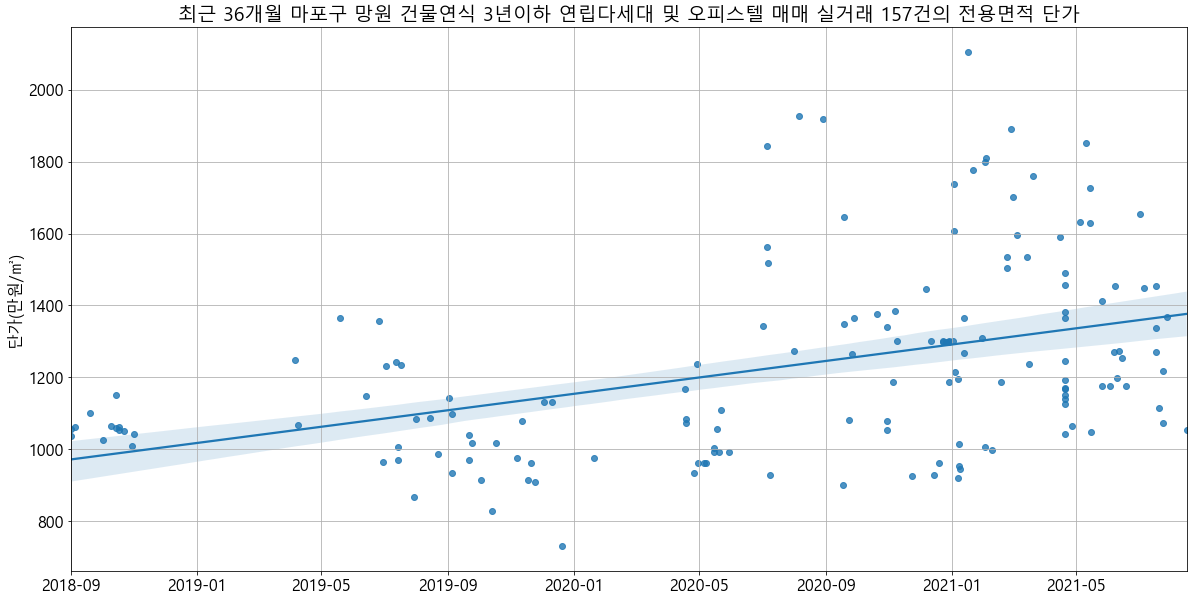

In [41]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/산포도.png'.format(target_gu, target_dong, date_today_record))

In [42]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

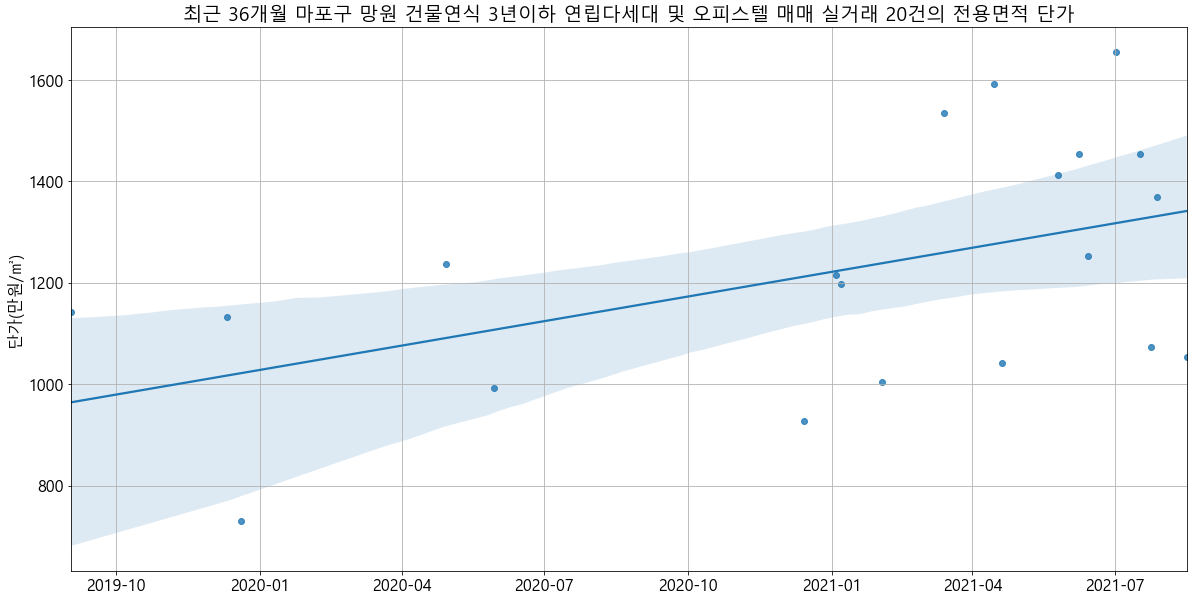

In [43]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/마지막_산포도.png'.format(target_gu, target_dong, date_today_record))

In [44]:
target_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/마지막_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [45]:
target_df2 = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(1894, 15)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약
1094447,서울특별시 마포구 망원동 236-18,동교로1길 20,한강그린빌(236-18),27.21,12700,4,2011.0,2.0,2013-10-08,466.740169,10.0,연립다세대,마포구,망원동,N
1094455,서울특별시 마포구 망원동 236-18,동교로1길 20,한강그린빌(236-18),29.76,21500,2,2011.0,0.0,2011-08-02,722.446237,10.0,연립다세대,마포구,망원동,N
1094472,서울특별시 마포구 망원동 236-2,동교로1길 22,한강그린1차아파트,60.18,32000,2,2011.0,2.0,2013-03-18,531.738119,10.0,아파트,마포구,망원동,N
1094482,서울특별시 마포구 망원동 236-2,동교로1길 22,한강그린1차아파트,65.53,34000,4,2011.0,3.0,2014-08-25,518.846330,10.0,아파트,마포구,망원동,N
1094486,서울특별시 마포구 망원동 236-2,동교로1길 22,한강그린1차아파트,67.06,45500,7,2011.0,1.0,2012-05-07,678.496868,10.0,아파트,마포구,망원동,N


In [46]:
target_df2 = get_index_applied_prices(target_df2)

<AxesSubplot:title={'center':'마포구 망원 계약날짜기준 건물연식 3년이하 연립다세대 및 오피스텔 매매 실거래 1894건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

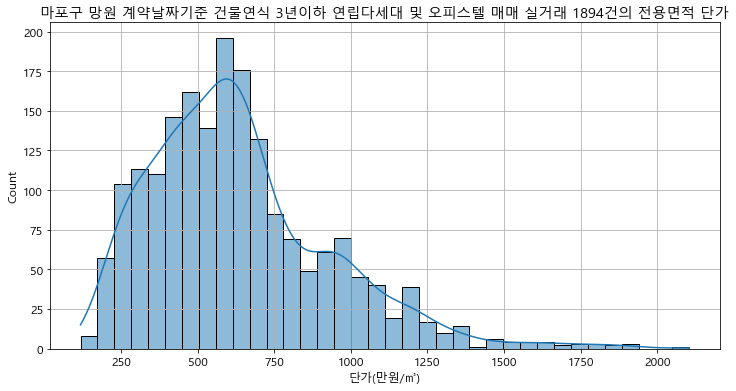

In [47]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [48]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '층', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '지수적용날짜', '지수적용단가', '부동산유형']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/전체_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [49]:
target_df3_30 = target_df3[
    (target_df3['전용면적(㎡)'] >= 28)
    &(target_df3['전용면적(㎡)'] <= 32)
]

In [50]:
target_df3_30.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/전체_실거래가_30.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [51]:
concat_df = pd.concat([target_df2])

In [52]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [53]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [54]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '지수적용날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(889, 19)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약,지수적용단가,지수적용날짜,단가평균,지수적용단가평균
0,서울특별시 마포구 망원동 236-18,동교로1길 20,한강그린빌(236-18),27.21,12700,4,2011.0,2.0,2013-10-08,466.740169,10.0,연립다세대,마포구,망원동,N,702.366394,2021-05-01,594.593203,861.348532
1,서울특별시 마포구 망원동 236-18,동교로1길 20,한강그린빌(236-18),29.76,21500,2,2011.0,0.0,2011-08-02,722.446237,10.0,연립다세대,마포구,망원동,N,1020.330669,2021-05-01,594.593203,861.348532
2,서울특별시 마포구 망원동 236-2,동교로1길 22,한강그린1차아파트,60.18,32000,2,2011.0,2.0,2013-03-18,531.738119,10.0,아파트,마포구,망원동,N,800.692314,2021-05-01,576.360439,859.750228
3,서울특별시 마포구 망원동 236-2,동교로1길 22,한강그린1차아파트,65.53,34000,4,2011.0,3.0,2014-08-25,518.846330,10.0,아파트,마포구,망원동,N,780.357877,2021-05-01,576.360439,859.750228
4,서울특별시 마포구 망원동 236-2,동교로1길 22,한강그린1차아파트,67.06,45500,7,2011.0,1.0,2012-05-07,678.496868,10.0,아파트,마포구,망원동,N,998.200492,2021-05-01,576.360439,859.750228


In [55]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df.head()

(297, 19)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,일괄계약,지수적용단가,지수적용날짜,단가평균,지수적용단가평균
1,서울특별시 마포구 망원동 236-18,동교로1길 20,한강그린빌(236-18),29.76,21500,2,2011.0,0.0,2011-08-02,722.446237,10.0,연립다세대,마포구,망원동,N,1020.330669,2021-05-01,594.593203,861.348532
4,서울특별시 마포구 망원동 236-2,동교로1길 22,한강그린1차아파트,67.06,45500,7,2011.0,1.0,2012-05-07,678.496868,10.0,아파트,마포구,망원동,N,998.200492,2021-05-01,576.360439,859.750228
5,서울특별시 마포구 망원동 236-4,희우정로13길 29,삼성캐슬(236-4),45.30,47000,5,2017.0,3.0,2020-01-18,1037.527594,4.0,연립다세대,마포구,망원동,N,1216.881710,2021-05-01,1037.527594,1216.881710
8,서울특별시 마포구 망원동 239-0,희우정로13길 9,월드,100.93,38000,7,2004.0,2.0,2006-12-21,376.498563,17.0,아파트,마포구,망원동,N,737.561551,2021-05-01,351.151344,673.957011
18,서울특별시 마포구 망원동 338-12,월드컵로11길 83,현대힐타운,14.44,9400,4,2011.0,1.0,2012-07-30,650.969529,10.0,연립다세대,마포구,망원동,N,971.942953,2021-05-01,656.725032,980.536320


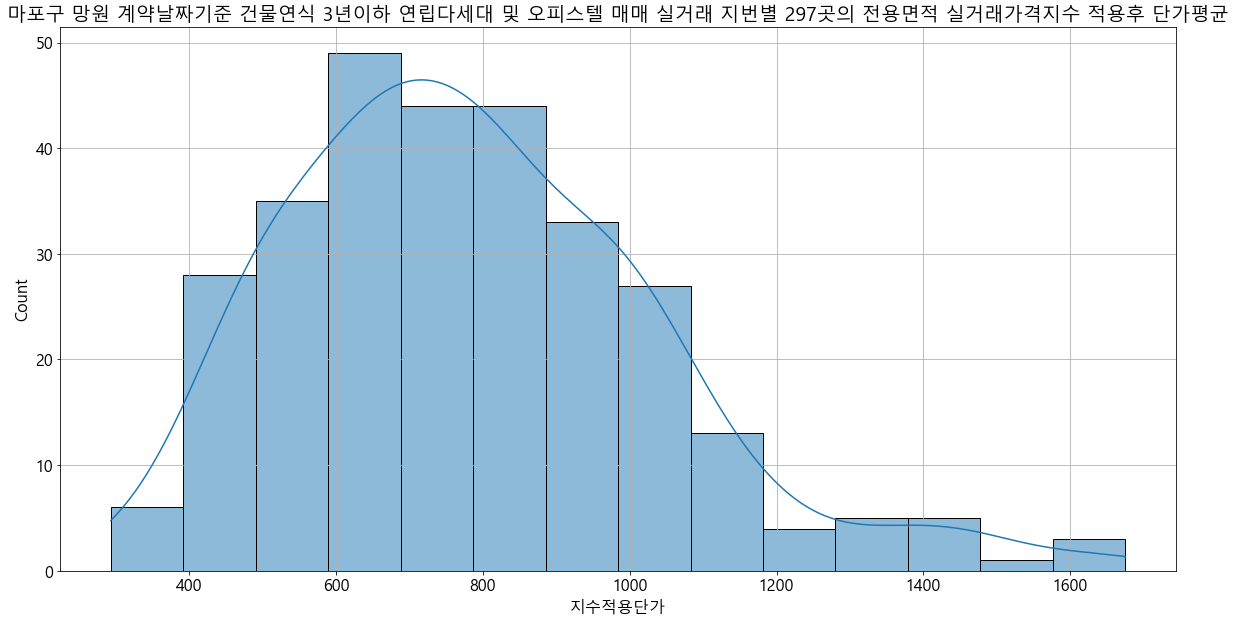

In [56]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/지번별_분포도.png'.format(target_gu, target_dong, date_today_record))

In [57]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [58]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '층', '계약날짜', '단가(만원/㎡)', '지수적용날짜', '지수적용단가', '부동산유형']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

,지번주소,건물(단지)명,건축년도,전용면적(㎡),층,마지막_계약날짜,단가(만원/㎡),지수적용날짜,지수적용단가,부동산유형
0,서울특별시 마포구 망원동 236-18,한강그린빌(236-18),2011.0,29.76,2,2011-08-02,722.446237,2021-05-01,1020.330669,연립다세대
1,서울특별시 마포구 망원동 236-2,한강그린1차아파트,2011.0,67.06,7,2012-05-07,678.496868,2021-05-01,998.200492,아파트
2,서울특별시 마포구 망원동 236-4,삼성캐슬(236-4),2017.0,45.30,5,2020-01-18,1037.527594,2021-05-01,1216.881710,연립다세대
3,서울특별시 마포구 망원동 239-0,월드,2004.0,100.93,7,2006-12-21,376.498563,2021-05-01,737.561551,아파트
4,서울특별시 마포구 망원동 338-12,현대힐타운,2011.0,14.44,4,2012-07-30,650.969529,2021-05-01,971.942953,연립다세대


In [59]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/전체_마지막_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)